In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661205 sha256=89621394a09e822ed382befaf6a903cd1f8f4bd5104d365f447896d0bf90b567
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [2]:
!nvidia-smi

Fri Feb  2 18:40:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
cuda_kernel = """

#include <cstdint>

extern "C" {

__device__ int height;
__device__ int width;

// shared memory struct
struct Shared
{
    uint8_t image_r[32*32];
    uint8_t image_g[32*32];
    uint8_t image_b[32*32];
    int energy[1];
    int cur_energy_change[8][12];
    int energy_changes[8];
    int swaps[1];
};


// calculates RGB difference from 2 pixels
// input: shared_image arrays, indices of 2 pixels
// output: RGB difference of 2 pixels
__device__ int pixelDifference(uint8_t* shared_image_r,uint8_t* shared_image_g, uint8_t* shared_image_b,  int x1, int x2) {
    return abs(shared_image_r[x1] - shared_image_r[x2]) + abs(shared_image_g[x1] - shared_image_g[x2]) +
      abs(shared_image_b[x1] - shared_image_b[x2]);
}

// calculates energy of a pixel (the sum of the RGB differences from the surrounding pixels)
// input: shared_image arrays, index of a pixel
// output: total energy of a pixel
__device__ int pixelEnergy(uint8_t* shared_image_r,uint8_t* shared_image_g, uint8_t* shared_image_b, int x){

  int energy = 0;

  if(x % height + 1 < width){
      energy += pixelDifference(shared_image_r,shared_image_g,shared_image_b, x, x + 1);
  }
  if(x % height - 1 >= 0){
      energy += pixelDifference(shared_image_r,shared_image_g,shared_image_b,x,  x - 1);
  }
  if(x / width + 1 < height){
      energy += pixelDifference(shared_image_r,shared_image_g,shared_image_b,x, x + width);
  }
  if(x / width - 1 >= 0){
      energy += pixelDifference(shared_image_r,shared_image_g,shared_image_b,x, x - width);
  }

  return energy;
}

// copies an image to shared memory and calculates initial energy
// input: image array, energy pointer for the result, image dimensions
__global__ void copy_image_to_shared_memory(uint8_t* image, int* energy, int image_height, int image_width) {

    extern __shared__ Shared sharedmem[];

    // set start values
    if(threadIdx.x==0 && threadIdx.y==0){
        sharedmem->energy[0] = 0;
        sharedmem->swaps[0] = 0;
        height = image_height;
        width = image_width;
    }


     __syncthreads();

    int start = 0;
    for (int j = 0; j < gridDim.x; j++){

        start = ((j + blockIdx.x)%gridDim.x) * blockDim.x;

        if (start + threadIdx.x +  blockDim.x *threadIdx.y < 32 * 32){
             sharedmem->image_r[(threadIdx.x + blockDim.x *threadIdx.y)  ] =  image[start + (threadIdx.x + blockDim.x *threadIdx.y) * 3];
             sharedmem->image_g[(threadIdx.x + blockDim.x *threadIdx.y) ] =  image[start + (threadIdx.x + blockDim.x *threadIdx.y) * 3 + 1];
             sharedmem->image_b[(threadIdx.x + blockDim.x *threadIdx.y)] =  image[start + (threadIdx.x + blockDim.x *threadIdx.y) * 3 + 2];
        }

        __syncthreads();
    }

    atomicAdd(&sharedmem->energy[0], pixelEnergy(sharedmem->image_r,sharedmem->image_g,sharedmem->image_b, (threadIdx.x + blockDim.x * threadIdx.y)));

    __syncthreads();
    if(threadIdx.x==0 && threadIdx.y==0){
       energy[0] = sharedmem->energy[0];
    }
}


// get image from shared memory
// input: image, energy and swaps pointers for the results
__global__ void get_image(uint8_t* image, int* energy, int *swaps){
    extern __shared__ Shared sharedmem[];

    int start = 0;
    for (int j = 0; j < gridDim.x; j++) {
        start = ((j + blockIdx.x) % gridDim.x) * blockDim.x;

        if (start + threadIdx.x + blockDim.x *threadIdx.y < 32 * 32) {
            int idx = start + (threadIdx.x + blockDim.x *threadIdx.y) * 3;
            image[idx] = sharedmem->image_r[(threadIdx.x + blockDim.x *threadIdx.y)  ];       // R komponenta
            image[idx + 1] = sharedmem->image_g[(threadIdx.x + blockDim.x *threadIdx.y)  ];   // G komponenta
            image[idx  + 2] = sharedmem->image_b[(threadIdx.x + blockDim.x *threadIdx.y)];   // B komponenta
        }
        __syncthreads();
    }

    if(threadIdx.x == 0 && threadIdx.y==0){
      energy[0] = sharedmem->energy[0];
      swaps[0] = sharedmem->swaps[0];
    }
}

// calculate pixel energy with values of the swapped
// input: shared_image arrays, index of the current pixel, indices of the pixels that are being swapped
// output: new pixel energy
__device__ int pixelEnergy_change(uint8_t* shared_image_r,uint8_t* shared_image_g, uint8_t* shared_image_b, int x, int changed1, int changed2){

  int energy = 0;

  if(x % height + 1 < width){
      int idx = x + 1;
      if(idx == changed1)
        idx = changed2;
      else if(idx == changed2)
        idx = changed1;

      if(x==changed1)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed2, idx);
      else if(x==changed2)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed1, idx);
      else
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  x, idx);
  }
  if(x % height - 1 >= 0){
      int idx = x - 1;
      if(idx == changed1)
        idx = changed2;
      else if(idx == changed2)
        idx = changed1;

      if(x==changed1)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed2, idx);
      else if(x==changed2)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed1, idx);
      else
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  x, idx);
  }
  if(x / width + 1 < height){
      int idx = x + width;
      if(idx == changed1)
        idx = changed2;
      else if(idx == changed2)
        idx = changed1;

      if(x==changed1)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed2, idx);
      else if(x==changed2)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed1, idx);
      else
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  x, idx);
  }
  if(x / width - 1 >= 0){
      int idx = x - width;
      if(idx == changed1)
        idx = changed2;
      else if(idx == changed2)
        idx = changed1;

      if(x==changed1)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed2, idx);
      else if(x==changed2)
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  changed1, idx);
      else
        energy += pixelDifference(shared_image_r,shared_image_g, shared_image_b,  x, idx);
  }

  return energy;
}

// swap two values
__device__ void swapValues(uint8_t& a, uint8_t& b) {
    uint8_t tmp = a;
    a = b;
    b = tmp;
}


// simulate annealing on 32x32 image
// input: current temperature, array of random indices, array of random indices for swapping, random number between 0 and 1
__global__ void simulated_annealing(float current_temp, int *random_ids, int *changed_ids, float probability) {

    extern __shared__ Shared sharedmem[];
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    // calculate new energy of the surrounding pixels which can be affected (12 at most)
    int i1;
    int i2;
    if(changed_ids[ty]-1 == random_ids[ty]){
      i1 = (tx % 4 - 1); // 2
      i2 =  width * (tx/4 - 1); // 0
    }
    else{
      i1 = (tx % 3 - 1);
      i2 =  width * (tx/3 - 1);
    }

    if(random_ids[ty] + i1 + i2 >= 0 && random_ids[ty] + i1 + i2 < width * height && random_ids[ty]/width == (random_ids[ty] + i1)/width)
        sharedmem->cur_energy_change[ty][tx] = pixelEnergy_change(sharedmem->image_r,
                                                                  sharedmem->image_g,
                                                                  sharedmem->image_b,
                                                                  random_ids[ty] + i1 + i2,
                                                                  random_ids[ty],
                                                                  changed_ids[ty]) -
                                               pixelEnergy(sharedmem->image_r,
                                                           sharedmem->image_g,
                                                           sharedmem->image_b,
                                                           random_ids[ty] + i1 + i2);
    else
      sharedmem->cur_energy_change[ty][tx] = 0;



    __syncthreads();

    // calculate total energy change
    if (tx == 0) {
        int total_energy_change = 0;
        for (int i = 0; i < blockDim.x; i++) {
            total_energy_change += sharedmem->cur_energy_change[ty][i];
        }
        sharedmem->energy_changes[ty] =  total_energy_change;
    }

    __syncthreads();



    if (tx== 0 && ty == 0) {

        // find the best energy change
        int best_dE = INT_MAX;
        int best_changed_idx = -1;
        int best_random_idx = -1;

        for (int i = 0; i < blockDim.y; i++) {
            if (sharedmem->energy_changes[i] < best_dE) {
                best_dE = sharedmem->energy_changes[i];
                best_changed_idx = changed_ids[i];
                best_random_idx = random_ids[i];
            }
        }


          // if best_dE is negative (energy has increased), or is a random number less than the exponential function exp2f(-best_dE / current_temp) => swap
          if (best_dE < 0 || probability < exp2f(float(-best_dE) / current_temp)) {

                swapValues(sharedmem->image_r[best_changed_idx], sharedmem->image_r[best_random_idx]);
                swapValues(sharedmem->image_g[best_changed_idx], sharedmem->image_g[best_random_idx]);
                swapValues(sharedmem->image_b[best_changed_idx], sharedmem->image_b[best_random_idx]);

                // increment the number of swaps and change the energy
                sharedmem->energy[0] += best_dE;
                sharedmem->swaps[0] += 1;
            }

      }
    }
}

"""

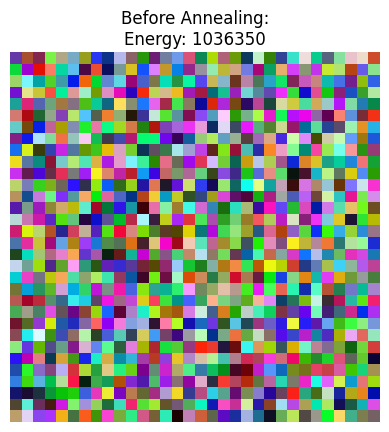

  0%|          | 0/10000000 [00:00<?, ?it/s]

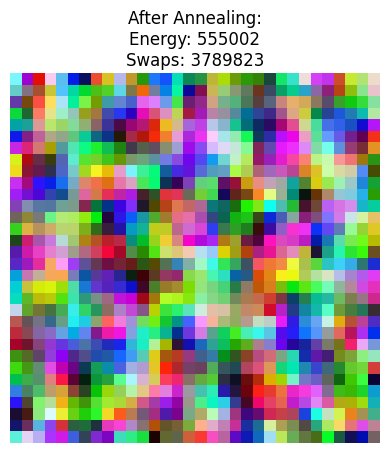

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
from tqdm.notebook import tqdm
import random

# allocate memory in cuda and return pointers
def cuda_alloc(*args):
  return [cuda.mem_alloc(arg.nbytes) for arg in args]

# copy from python to cuda using pointers
def to_cuda(*args):
  cuda_ptrs = cuda_alloc(*args)
  for dst, src in zip(cuda_ptrs, args):
     cuda.memcpy_htod(dst, src)
  return cuda_ptrs[0] if len(cuda_ptrs) == 1 else cuda_ptrs


def simulator(image=np.random.randint(0, 255, (32, 32, 3), dtype=np.uint8),
              block_dim=(1024, 1, 1),
              sa_block_dim=(12, 8, 1),
              start_temp=100.0,
              total_iterations=10_000_000):


  width = image.shape[1]
  height = image.shape[0]
  grid_dim = (1, 1, 1)

  # compile cuda kernel and get functions
  mod = SourceModule(cuda_kernel, no_extern_c=True)
  copy_image_to_shared_memory_kernel = mod.get_function("copy_image_to_shared_memory")
  get_image_kernel = mod.get_function("get_image")
  simulated_annealing_kernel = mod.get_function("simulated_annealing")

  # initialize some input parameters and copy to cuda
  image_device = to_cuda(image.flatten())
  result_init_energy_host = np.zeros(1, dtype=np.int32)
  result_init_energy_device = to_cuda(result_init_energy_host)
  swaps_host = np.zeros(1, dtype=np.int32)
  swaps_device = to_cuda(swaps_host)
  res = np.zeros(1024*3, dtype=np.uint8)
  res_image_device = to_cuda(res)
  energy_final =np.zeros(1, dtype=np.int32)
  energy_final_device = to_cuda(energy_final)
  # allocate memory for random indices
  random_ids_device = cuda.mem_alloc(sa_block_dim[1] * 4)
  changed_ids_device = cuda.mem_alloc(sa_block_dim[1] * 4)

  # copy the image to shared memory and calculate initial energy
  copy_image_to_shared_memory_kernel(image_device, result_init_energy_device, np.int32(height), np.int32(width),
      block=block_dim, grid=grid_dim, shared=image.nbytes + 4*(12*8+1+8+1))
  cuda.Context.synchronize()
  cuda.memcpy_dtoh(result_init_energy_host, result_init_energy_device)

  # plot data before annealing
  plt.imshow(image)
  plt.axis('off')
  plt.title(f'Before Annealing:\nEnergy: {result_init_energy_host[0]}')
  plt.show()

  # simulate iterations of annealing
  for i in tqdm(range(total_iterations)):

    # update current temperature
    current_temp = start_temp * (1 - i / total_iterations)

    # generate random indices and probability
    moves = np.random.randint(0, 2, sa_block_dim[1])
    random_x = np.random.randint(0,height - 1, sa_block_dim[1], dtype=np.int32)
    random_y = np.random.randint(0,width - 1, sa_block_dim[1], dtype=np.int32)
    random_ids = random_x * width + random_y
    random_ids = np.array(random_ids, dtype=np.int32)
    moves = np.random.randint(0, 2, sa_block_dim[1])
    changed_ids = random_ids + np.array(list(map(lambda x: 1 if x == 1 else width, moves)), dtype=np.int32)
    changed_ids = np.array(changed_ids, dtype=np.int32)
    probability = random.random()

    # copy indices to cuda
    cuda.memcpy_htod(random_ids_device, random_ids)
    cuda.memcpy_htod(changed_ids_device, changed_ids)
    # simulate annealing
    simulated_annealing_kernel(np.float32(current_temp), random_ids_device, changed_ids_device, np.float32(probability),
        block=sa_block_dim,  grid=grid_dim, shared=(image.nbytes + (12*8+1+8+1)*4)
    )




  cuda.Context.synchronize()

  # get image, energy and number of swaps after annealing
  get_image_kernel(res_image_device,energy_final_device, swaps_device, block=block_dim, grid=grid_dim,  shared=image.nbytes + 4*(12*8+1+8+1))
  cuda.memcpy_dtoh(energy_final, energy_final_device)
  cuda.memcpy_dtoh(res, res_image_device)
  cuda.memcpy_dtoh(swaps_host, swaps_device)

  # plot final image, energy and number of swaps
  plt.imshow(res.reshape(32,32,3))
  plt.axis('off')
  plt.title(f'After Annealing:\nEnergy: {energy_final[0]}\nSwaps: {swaps_host[0]}')
  plt.show()



def main():
  simulator()


if __name__ == "__main__":
  main()